<a href="https://colab.research.google.com/github/thousandoaks/Intro-Causal-Inference/blob/main/code/Estimating_the_effect_of_a_Member_Rewards_program.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Suppose that a website has a membership rewards program where customers receive additional benefits if they sign up. How do we know if the program is effective? Here the relevant causal question is: > What is the impact of offering the membership rewards program on total sales?

And the equivalent counterfactual question is, > If the current members had not signed up for the program, how much less would they have spent on the website?

In formal language, we are interested in the Average Treatment Effect on the Treated (ATT).

In [13]:
pip install dowhy

In [14]:
import dowhy

In [3]:
from scipy import stats

## 0. Data exploration

Suppose that the rewards program was introduced in January 2019. The outcome variable is the total spends at the end of the year. We have data on all monthly transactions of every user and on the time of signup for those who chose to signup for the rewards program. Here’s what the data looks like.

In [2]:
# Creating some simulated data for our example example
import pandas as pd
import numpy as np
num_users = 10000
num_months = 12

signup_months = np.random.choice(np.arange(1, num_months), num_users) * np.random.randint(0,2, size=num_users)
df = pd.DataFrame({
    'user_id': np.repeat(np.arange(num_users), num_months),
    'signup_month': np.repeat(signup_months, num_months), # signup month == 0 means customer did not sign up
    'month': np.tile(np.arange(1, num_months+1), num_users), # months are from 1 to 12
    'spend': np.random.poisson(500, num_users*num_months) #np.random.beta(a=2, b=5, size=num_users * num_months)*1000 # centered at 500
})
# Assigning a treatment value based on the signup month
df["treatment"] = (1-(df["signup_month"]==0)).astype(bool)
# Simulating effect of month (monotonically increasing--customers buy the most in December)
df["spend"] = df["spend"] - df["month"]*10
# The treatment effect (simulating a simple treatment effect of 100)
after_signup = (df["signup_month"] < df["month"]) & (df["signup_month"] !=0)
df.loc[after_signup,"spend"] = df[after_signup]["spend"] + 100
df

,user_id,signup_month,month,spend,treatment
0,0,0,1,480,False
1,0,0,2,463,False
2,0,0,3,456,False
3,0,0,4,517,False
4,0,0,5,470,False
...,...,...,...,...,...
119995,9999,3,8,489,True
119996,9999,3,9,499,True
119997,9999,3,10,478,True
119998,9999,3,11,518,True


## Please observe that, for the syntetic data, the effect on spending of being in the reward programme is 100 monetary units

In [7]:
df[df['user_id']==0]

,user_id,signup_month,month,spend,treatment
0,0,0,1,480,False
1,0,0,2,463,False
2,0,0,3,456,False
3,0,0,4,517,False
4,0,0,5,470,False
5,0,0,6,431,False
6,0,0,7,415,False
7,0,0,8,452,False
8,0,0,9,390,False
9,0,0,10,422,False


In [76]:
stats.pearsonr(df['treatment'], df['spend'])

There seems to be a significant "correlation" between the rewards programme and spending

Time plays a crucial role in modeling this problem.

Rewards signup can affect the future transactions. In fact, the transaction prior to the rewards signup can be assumed to cause the rewards signup decision. Therefore we can split up the variables for each user in terms of

Activity prior to the treatment (causes the treatment)

Activity after the treatment (is the outcome of applying treatment)

Of course, many important variables that affect signup and total spend are missing (e.g., the type of products bought, length of a user’s account, geography, etc.). So we’ll need a node denoting Unobserved Confounders.

# I. Formulating the causal model
## Signing up in month 3

In [8]:
i = 3

In [51]:
# Post-process the data based on the graph and the month of the treatment (signup)
df_i_signupmonth = df[df.signup_month.isin([0,i])].groupby(["user_id", "signup_month", "treatment"]).apply(
    lambda x: pd.Series({'pre_spends': np.sum(np.where(x.month < i, x.spend,0))/np.sum(np.where(x.month<i, 1,0)),
                        'post_spends': np.sum(np.where(x.month > i, x.spend,0))/np.sum(np.where(x.month>i, 1,0)) })
).reset_index()
print(df_i_signupmonth)

      user_id  signup_month  treatment  pre_spends  post_spends
0           0             0      False  466.333333      415.500
1           1             0      False  465.333333      415.000
2           3             0      False  457.000000      408.375
3           7             0      False  472.000000      424.375
4           8             0      False  488.333333      407.875
...       ...           ...        ...         ...          ...
5355     9990             0      False  483.333333      427.375
5356     9991             0      False  496.000000      416.000
5357     9992             0      False  478.333333      415.875
5358     9995             4       True  485.666667      512.625
5359     9996             0      False  469.666667      431.500

[5360 rows x 5 columns]


In [57]:
causal_graph = """digraph {
treatment[label="Program Signup in month i"];
pre_spends;
post_spends;
Z->treatment;
U[label="Unobserved Confounders"];
pre_spends -> treatment;
pre_spends -> post_spends;
treatment->post_spends;
signup_month->post_spends; signup_month->pre_spends;
signup_month->treatment;
U->treatment; U->pre_spends; U->post_spends;
}"""


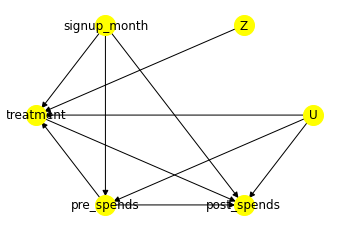

In [58]:
model = dowhy.CausalModel(data=df_i_signupmonth,
                     graph=causal_graph.replace("\n", " "),
                     treatment="treatment",
                     outcome="post_spends")
model.view_model()


# II. Identifying the causal effect

In [59]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                        
────────────(Expectation(post_spends|signup_month,pre_spends))
d[treatment]                                                  
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→post_spends then P(post_spends|treatment,signup_month,pre_spends,U) = P(post_spends|treatment,signup_month,pre_spends)

### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(post_spends, [Z])*Derivative([treatment], [Z])**(-1))
Estimand assumption 1, As-if-random: If U→→post_spends then ¬(U →→{Z})
Estimand assumption 2, Exclusion: If we remove {Z}→{treatment}, then ¬({Z}→post_spends)

### Estimand : 3
Estimand name: frontdoor
No such variable found!



# III. Estimating the effect

In [60]:
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor1.propensity_score_matching",
                                target_units="att")
print(estimate)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: post_spends~treatment+signup_month+pre_spends
Target units: att

## Estimate
Mean value: 96.16569086651054



The analysis tells us the Average Treatment Effect on the Treated (ATT). That is, the average effect on total spend for the customers that signed up for the Rewards Program in month i=3 (compared to the case where they had not signed up).

# IV. Refuting the estimate

In [61]:
refutation = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter",
                     placebo_type="permute", num_simulations=4)
print(refutation)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

Refute: Use a Placebo Treatment
Estimated effect:96.16569086651054
New effect:-0.13165983606557374
p value:0.4393392560977516



# Let's repeat the analysis, this time for month 6

In [21]:
i=6

In [22]:
# Post-process the data based on the graph and the month of the treatment (signup)
df_i_signupmonth = df[df.signup_month.isin([0,i])].groupby(["user_id", "signup_month", "treatment"]).apply(
    lambda x: pd.Series({'pre_spends': np.sum(np.where(x.month < i, x.spend,0))/np.sum(np.where(x.month<i, 1,0)),
                        'post_spends': np.sum(np.where(x.month > i, x.spend,0))/np.sum(np.where(x.month>i, 1,0)) })
).reset_index()
print(df_i_signupmonth)

causal_graph = """digraph {
treatment[label="Program Signup in month i"];
pre_spends;
post_spends;
Z->treatment;
U[label="Unobserved Confounders"];
pre_spends -> treatment;
treatment->post_spends;
signup_month->post_spends; signup_month->pre_spends;
signup_month->treatment;
U->treatment; U->pre_spends; U->post_spends;
}"""



model = dowhy.CausalModel(data=df_i_signupmonth,
                     graph=causal_graph.replace("\n", " "),
                     treatment="treatment",
                     outcome="post_spends")


identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)



estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor1.propensity_score_matching",
                                target_units="att")
print(estimate)




refutation = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter",
                     placebo_type="permute", num_simulations=2)
print(refutation)

      user_id  signup_month  treatment  pre_spends  post_spends
0           0             0      False       477.2   403.833333
1           1             0      False       456.2   404.000000
2           3             0      False       463.8   393.666667
3           7             0      False       470.0   418.500000
4           8             0      False       474.6   398.000000
...       ...           ...        ...         ...          ...
5389     9989             0      False       460.4   408.166667
5390     9990             0      False       471.0   417.833333
5391     9991             0      False       493.0   404.500000
5392     9992             0      False       460.6   408.166667
5393     9996             0      False       476.6   411.333333

[5394 rows x 5 columns]
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                        
────────────(Expectation(post_spends|signup_mont

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: post_spends~treatment+signup_month+pre_spends
Target units: att

## Estimate
Mean value: 84.20209689081702



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Refute: Use a Placebo Treatment
Estimated effect:84.20209689081702
New effect:0.5104844540853223
p value:0.3688147801994104



# Let's repeat the analysis, this time for month 9

In [23]:
i=9

In [24]:
# Post-process the data based on the graph and the month of the treatment (signup)
df_i_signupmonth = df[df.signup_month.isin([0,i])].groupby(["user_id", "signup_month", "treatment"]).apply(
    lambda x: pd.Series({'pre_spends': np.sum(np.where(x.month < i, x.spend,0))/np.sum(np.where(x.month<i, 1,0)),
                        'post_spends': np.sum(np.where(x.month > i, x.spend,0))/np.sum(np.where(x.month>i, 1,0)) })
).reset_index()
print(df_i_signupmonth)

causal_graph = """digraph {
treatment[label="Program Signup in month i"];
pre_spends;
post_spends;
Z->treatment;
U[label="Unobserved Confounders"];
pre_spends -> treatment;
treatment->post_spends;
signup_month->post_spends; signup_month->pre_spends;
signup_month->treatment;
U->treatment; U->pre_spends; U->post_spends;
}"""



model = dowhy.CausalModel(data=df_i_signupmonth,
                     graph=causal_graph.replace("\n", " "),
                     treatment="treatment",
                     outcome="post_spends")


identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)



estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor1.propensity_score_matching",
                                target_units="att")
print(estimate)




refutation = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter",
                     placebo_type="permute", num_simulations=2)
print(refutation)

      user_id  signup_month  treatment  pre_spends  post_spends
0           0             0      False     460.500   388.666667
1           1             0      False     448.125   397.000000
2           3             0      False     448.250   385.333333
3           7             0      False     459.250   404.333333
4           8             0      False     454.250   384.666667
...       ...           ...        ...         ...          ...
5417     9989             0      False     451.875   391.333333
5418     9990             0      False     465.625   379.000000
5419     9991             0      False     465.875   395.000000
5420     9992             0      False     452.750   388.333333
5421     9996             0      False     462.875   397.333333

[5422 rows x 5 columns]
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                        
────────────(Expectation(post_spends|signup_mont

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: post_spends~treatment+signup_month+pre_spends
Target units: att

## Estimate
Mean value: 77.23312883435582



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Refute: Use a Placebo Treatment
Estimated effect:77.23312883435582
New effect:2.0323790047716432
p value:0.0007978362201020439

